In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime
from datetime import datetime, timedelta, date
import warnings

#settings
warnings.filterwarnings("ignore")

appearances_df = pd.read_csv("../raw_data/appearances.csv")
clubs_df = pd.read_csv("../raw_data/clubs.csv")
games_df = pd.read_csv("../raw_data/games.csv")
players_df = pd.read_csv("../raw_data/players.csv")

def players_df_preproc(players_df):
    #add year to game valuations
    now = datetime.now()
    players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
    players_df = players_df[players_df['date_of_birth'].isnull() == False]
    players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
    players_df['age'] = players_df['age'].round().astype(int) 

    # Calculate the contract remaining of each player
    players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
    players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
    players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 
    return players_df

def appearances_df_preproc(appearances_df):
    # add year to player appearances
    appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
    appearances_df['year']=appearances_df['datetime'].dt.year
    appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
    return appearances_df
"""
def games_and_appearances_df_preproc(games_df,appearances_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    return games_and_appearances_df

def feature_encode(df,column):
    dummies=pd.get_dummies(df[column], prefix_sep='_') 
    df = pd.concat([df, dummies], axis=1)
    return df
    """

'\ndef games_and_appearances_df_preproc(games_df,appearances_df):\n    games_df[\'datetime\']=pd.to_datetime(games_df[\'date\'], format="%Y-%m-%d")\n    games_df[\'year\']=games_df[\'datetime\'].dt.year\n    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]\n    games_and_appearances_df = appearances_df.merge(games_df, on=[\'game_id\'], how=\'left\')\n    return games_and_appearances_df\n\ndef feature_encode(df,column):\n    dummies=pd.get_dummies(df[column], prefix_sep=\'_\') \n    df = pd.concat([df, dummies], axis=1)\n    return df\n    '

In [2]:
def games_and_appearances_df_preproc(games_df,appearances_df,clubs_df):
    games_df['datetime']=pd.to_datetime(games_df['date'], format="%Y-%m-%d")
    games_df['year']=games_df['datetime'].dt.year
    games_df = games_df[(games_df.year > 2004 ) & (games_df.year < 2023 )]
    games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
    
    # here we impute the missing values with the minimum value of the corresponding league 
    # get the minimum value of the 'Domestic League' column
    min_value = clubs_df.groupby('domestic_competition_id')['total_market_value'].min()
        
    # fill missing values in 'Market Value' column with the minimum value of the 'Domestic League' column
    clubs_df['total_market_value'] = clubs_df.apply(lambda x: min_value[x['domestic_competition_id']] if pd.isnull(x['total_market_value']) else x['total_market_value'], axis=1)
    
    table_df = games_and_appearances_df
    
    # Join the tables on the home and away club IDs
    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='home_club_id', 
                            right_on='club_id')

    table_df = table_df.merge(clubs_df[['club_id', 'total_market_value']], 
                            how='left', 
                            left_on='away_club_id', 
                            right_on='club_id',
                            suffixes=('_home', '_away'))

    # Rename the columns to reflect the market value data
    table_df = table_df.rename(columns={'market_value_home': 'home_club_market_value',
                                        'market_value_away': 'away_club_market_value'})

    # Drop the redundant club_id columns
    table_df = table_df.drop(['club_id_home', 'club_id_away'], axis=1)
    
    games_and_appearances_df = table_df
    
    games_and_appearances_df.dropna(inplace=True)
    
    
    return games_and_appearances_df

In [3]:
#create a function to collate player stats
def player_stats(player_id, season, games_and_appearances_df):
    
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for',
                                                     'goals_against','clean_sheet',
                                                     'yellow_cards', 'red_cards','value_goals_for'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else np.nan if row['goals_against'] > 0
            else np.nan, axis=1)
        
        #engineering 
        df["value_goals_for"] = df.apply(lambda row: row['home_club_goals']*row['total_market_value_away'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals']*row['total_market_value_home'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        #print(df["value_goals_for"])
        
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                    'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                    'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum', 
                                                                    'red_cards':'sum',
                                                                    'value_goals_for':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df


In [4]:
# preprocessing function to return a dataframe
def data_cleaning(clubs_df,players_df,games_and_appearances_df):
    
    merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 
                                       'last_name', 'player_code', 'image_url', 'url'], axis=1)
    merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + 
                                                  ['club_value','squad_size','goals','goals_2022','games_2022',
                                                    'assists_2022','minutes_played_2022','goals_against_2022',
                                                    'goals_for_2022','clean_sheet_2022','value_goals_for_2022'])
    
    for player_id in merged_players_df.player_id.unique():
        club_id = players_df.current_club_id[(players_df.player_id==player_id)]
        try:
            merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
        except:
            merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
        merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))

    columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022',
             'clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship',
             'country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name',
             'contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur','value_goals_for_2022']
    merged_players_df=merged_players_df[columns] 

    #iterate through players
    for index in merged_players_df.index:
        id = merged_players_df.loc[index][0]
        name = merged_players_df.loc[index][1]
        
        season = 2022
        stats = player_stats(id, season, games_and_appearances_df)
  
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
        merged_players_df.at[index,'value_goals_for_{}'.format(season)]= stats['value_goals_for'][0]


    #drop nan
    merged_players_df0=merged_players_df.dropna(subset=['market_value_in_eur'])

    #drop columns
    drop_cols = ['player_id', 'clean_sheet_2022', 'name', 'sub_position', 'last_season',
                 'country_of_birth', 'current_club_name', 'current_club_domestic_competition_id', 
                 'agent_name', 'contract_expiration_date', 'club_value', 'squad_size', 'red_cards_2022']

    merged_players_df0 = merged_players_df0.drop(columns=drop_cols)
    
    return merged_players_df0

In [5]:
players_df = players_df[players_df['last_season']==2022]
players_df = players_df[players_df['position']=='Attack']

In [6]:
# test above functions

players_df = players_df_preproc(players_df)
appearances_df = appearances_df_preproc(appearances_df)
games_and_appearances_df = games_and_appearances_df_preproc(games_df,appearances_df,clubs_df)
df_cleaned = data_cleaning(clubs_df,players_df,games_and_appearances_df)

In [7]:
df_cleaned.head()

,games_2022,minutes_played_2022,goals_2022,assists_2022,goals_against_2022,goals_for_2022,position,foot,height_in_cm,age,country_of_citizenship,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,value_goals_for_2022,yellow_cards_2022
21969,11.0,367.0,0.0,0.0,25.0,5.0,Attack,Right,188,20,Russia,94,100000.0,100000.0,12.60,3.0
21970,14.0,1175.0,1.0,1.0,14.0,17.0,Attack,Right,175,37,Japan,94,250000.0,10000000.0,71.57,1.0
21971,17.0,1357.0,1.0,1.0,29.0,14.0,Attack,Right,189,33,Russia,94,300000.0,700000.0,35.28,3.0
21972,20.0,944.0,3.0,2.0,37.0,16.0,Attack,Right,186,27,Russia,460,500000.0,500000.0,40.32,3.0
21973,0.0,0.0,0.0,0.0,0.0,0.0,Attack,Right,183,30,Ukraine,94,250000.0,1300000.0,0.00,0.0


In [8]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 21969 to 28487
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   games_2022                   2087 non-null   float64
 1   minutes_played_2022          2087 non-null   float64
 2   goals_2022                   2087 non-null   float64
 3   assists_2022                 2087 non-null   float64
 4   goals_against_2022           2087 non-null   float64
 5   goals_for_2022               2087 non-null   float64
 6   position                     2087 non-null   object 
 7   foot                         2031 non-null   object 
 8   height_in_cm                 2087 non-null   int64  
 9   age                          2087 non-null   int64  
 10  country_of_citizenship       2087 non-null   object 
 11  term_days_remaining          2087 non-null   int64  
 12  market_value_in_eur          2087 non-null   float64
 13  highest_marke

In [9]:
df_cleaned.describe()

,games_2022,minutes_played_2022,goals_2022,assists_2022,goals_against_2022,goals_for_2022,height_in_cm,age,term_days_remaining,market_value_in_eur,highest_market_value_in_eur,value_goals_for_2022,yellow_cards_2022
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2.087000e+03,2.085000e+03,2087.000000,2087.000000
mean,10.026354,555.397221,1.783421,1.091998,14.206517,14.603737,176.114518,25.897460,633.982750,6.425994e+06,1.080746e+07,75.449046,1.172496
std,6.130709,458.016705,2.547921,1.626473,9.812870,11.922354,26.969903,4.475247,501.170235,1.364061e+07,2.034873e+07,97.145611,1.411482
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,64.000000,2.500000e+04,2.500000e+04,0.000000,0.000000
25%,5.000000,120.500000,0.000000,0.000000,6.000000,5.000000,175.000000,22.000000,94.000000,5.000000e+05,7.500000e+05,13.340000,0.000000
50%,11.000000,491.000000,1.000000,0.000000,15.000000,13.000000,180.000000,25.000000,460.000000,1.500000e+06,3.000000e+06,44.800000,1.000000
75%,15.000000,914.500000,3.000000,2.000000,22.000000,21.000000,185.000000,29.000000,917.000000,6.000000e+06,1.200000e+07,102.155000,2.000000
max,25.000000,2094.000000,27.000000,15.000000,51.000000,63.000000,202.000000,42.000000,3016.000000,1.800000e+08,2.000000e+08,1086.790000,8.000000


In [10]:
import seaborn as sns

<Axes: xlabel='value_goals_for_2022', ylabel='Count'>

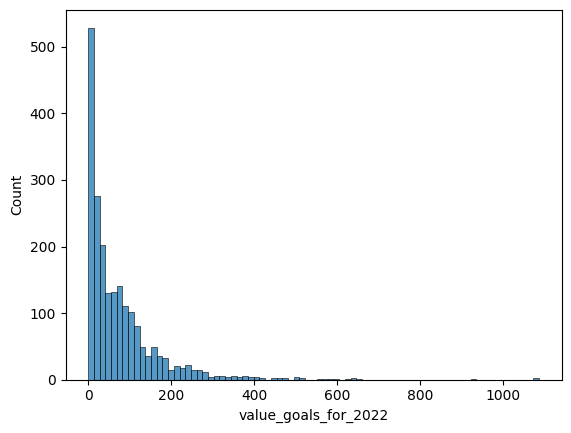

In [12]:
sns.histplot(df_cleaned["value_goals_for_2022"])